In [12]:
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import sys
import pickle as pkl
import face_recognition
sys.path.append('..')

from process_latents import ks
import data
import style
import config
from config import *
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## process the latents

In [ ]:
# !process_latents.py

In [4]:
# check if first generations are done
for d in os.listdir(DIR_PROCESSED):
    if 'generated_images_' in d:
        num = 0
        for num in range(30000):
            s = f'{num + 1:05d}.npy'
            if not os.path.exists(oj(DIR_PROCESSED, d, s)):
                break
        print(d, 'first', num, 'calculated')
        
    # save out first 300

generated_images_10000 first 300 calculated
generated_images_10 first 62 calculated
generated_images_1 first 1541 calculated
generated_images_0.1 first 8667 calculated
generated_images_0 first 321 calculated
generated_images_0.01 first 354 calculated


In [ ]:
# for the final selected dir, see if we are missing any projections
exists = np.zeros(30000)
for num in range(30000):
    s = f'{num + 1:05d}.npy'
    exists[num] = os.path.exists(oj(DIR_GEN, s))
print(np.sum(exists))

plt.plot(np.arange(30000)[exists == 0])
plt.grid()
print(sorted(os.listdir(DIR_GEN))[-1])

# analyze results after processing the latents

,reg_param,im_num,perceptual_loss,mean_abs_corr,mean_mse_dist,pred_H,pred_A,pred_G,pred_C,pred_B,pred_M,pred_S,pred_E,pred_W
0,10000,0,0.746571,1.0,1.363890e-09,0.416608,-0.324412,-2.777806,-0.349753,5.551168,1.625070,2.302401,-6.576551,0.231919
1,10000,1,0.790659,1.0,1.094799e-09,0.307900,-0.503152,-2.424377,-0.729286,9.954662,2.235315,-0.052102,-7.143328,-0.003069
2,10000,2,0.785664,1.0,1.312792e-09,0.106701,-0.252948,-0.910797,-0.447726,4.049523,-1.133978,2.600942,-7.088378,-0.905180
3,10000,3,0.724697,1.0,9.688613e-10,0.169111,0.105621,-1.674628,-0.162618,5.428327,-0.370509,3.067948,-4.228546,-0.181391
4,10000,4,0.725652,1.0,1.146150e-09,0.191494,-0.575225,-1.350129,-0.155680,8.397672,-0.880678,-0.830927,-7.271062,-0.855033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,10000,70,0.887193,1.0,2.197853e-09,0.034442,-0.882334,-0.040484,-0.636884,6.730826,-1.445130,0.318642,-9.250085,-0.984216
71,10000,71,0.807915,1.0,9.075913e-10,0.367177,-0.189725,-2.432274,-0.498457,8.756819,1.410776,4.684879,-4.565702,-0.025558
72,10000,72,0.770908,1.0,1.133644e-09,0.263469,-0.296690,-1.918431,-0.508080,6.687163,-0.131541,2.426863,-5.466881,-0.610774
73,10000,73,0.851701,1.0,1.627237e-09,0.256951,-0.440173,-1.477999,-0.602153,7.762608,-0.332773,1.939559,-4.182149,-1.474342


In [22]:
# latents_processed_file = oj(DIR_PROCESSED, 'processed_latents_300.pkl')
# df = pd.read_pickle(latents_processed_file)
df = pd.DataFrame([pkl.load(open(oj(DIR_PROCESSED, 'processed_latents', f), 'rb'))
 for f in sorted(os.listdir(oj(DIR_PROCESSED, 'processed_latents'))) if 'pkl' in f])
reg_params = df.reg_param.unique()
n = int(df.shape[0] / reg_params.size)

# add in all the label keys
df_labs = data.load_all_labs()[:n]
for reg_param in reg_params:
    for k in df_labs.keys():
        df.loc[df.reg_param == reg_param, k] = df_labs[k]

loading cached labels


In [ ]:
df.head()

### perceptual loss preservation

IndexError: single positional indexer is out-of-bounds

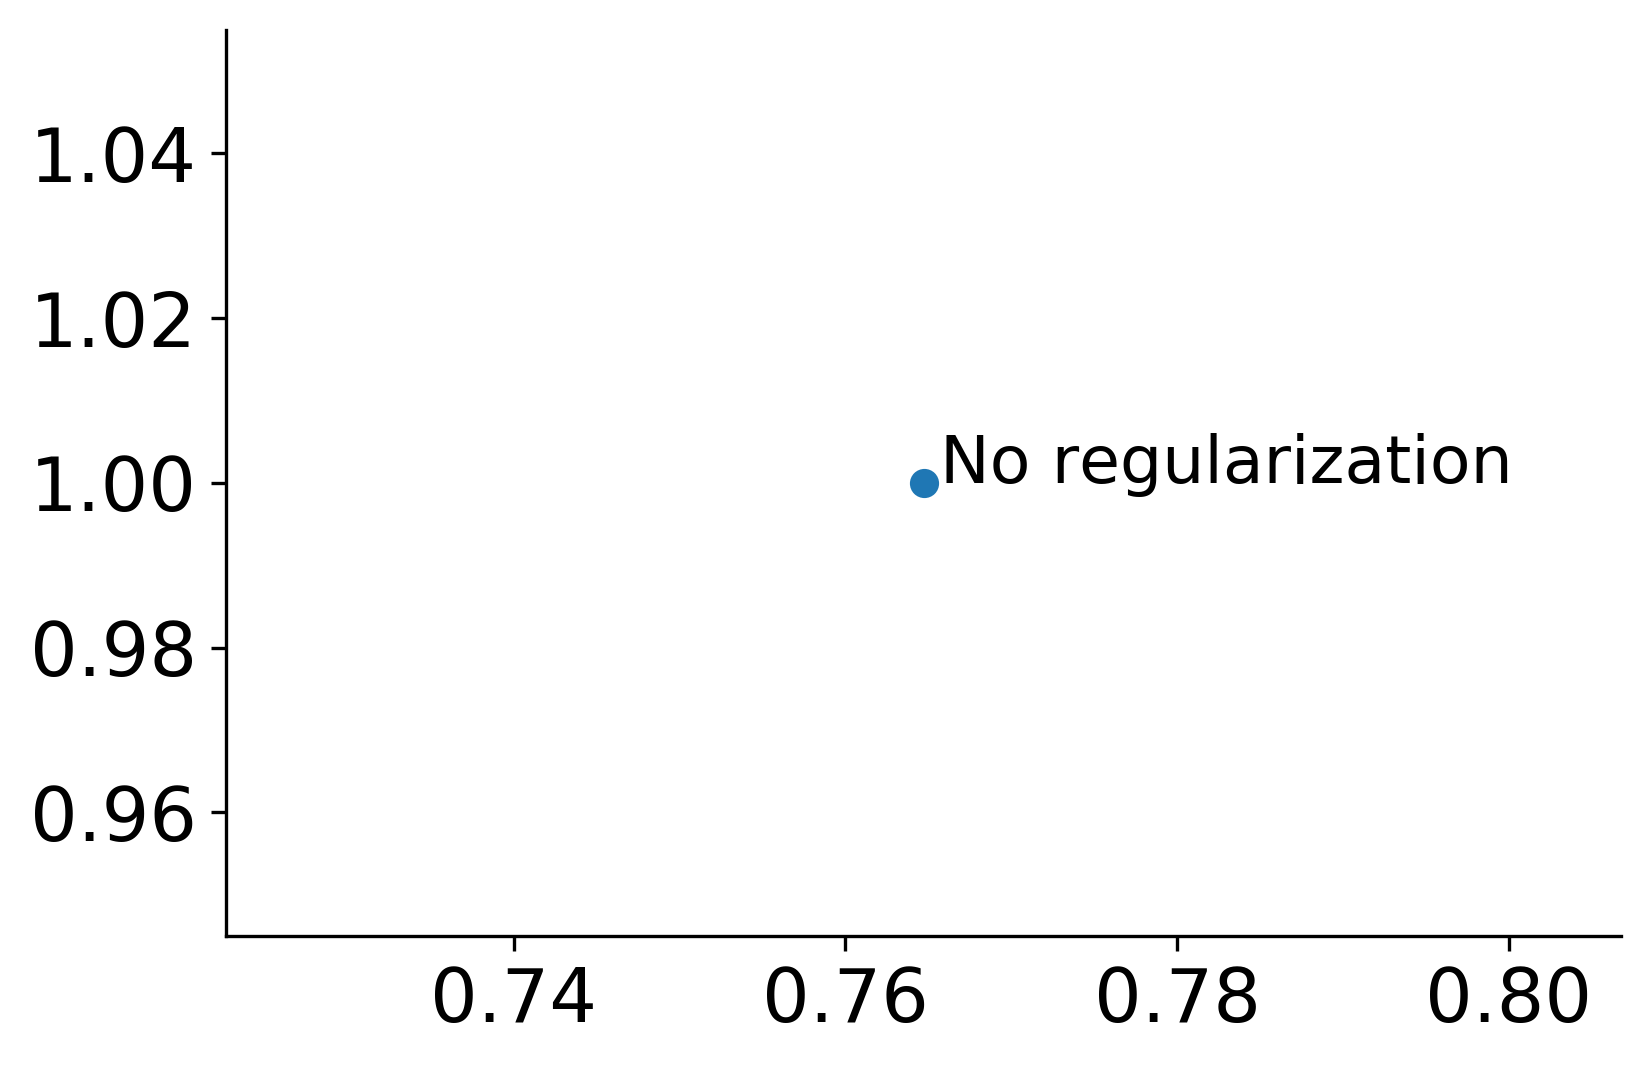

In [19]:
plt.figure(dpi=300)
means = df.groupby('reg_param').mean().reset_index()
ax = plt.gca()
plt.plot(means['perceptual_loss'], means['mean_abs_corr'], 'o-')

# annotate 0
r0 = means.iloc[0]
(x0, y0) = r0['perceptual_loss'] + 1e-3, r0['mean_abs_corr']
plt.text(x0, y0, 'No regularization')
'''
ax.annotate('local max', xy=(3, 1),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )
'''

# annotate 1
r1 = means.iloc[2]
(x1, y1) = r1['perceptual_loss'] + 1.5e-3, r1['mean_abs_corr'] - 3e-2
plt.plot(r1['perceptual_loss'], r1['mean_abs_corr'], marker='*', ms=13)
plt.text(x1, y1, 'Regularization = $10^{-1}$')

# annotate 2
r1 = means.iloc[-1]
(x1, y1) = r1['perceptual_loss'] + 1.5e-3, r1['mean_abs_corr'] - 3e-2
plt.plot(r1['perceptual_loss'], r1['mean_abs_corr'], marker='*', ms=13)
plt.text(x1, y1, 'Unexpanded latent space')

plt.ylabel('Mean absolute correlation\nbetween latent space vectors')
plt.xlabel('Perceptual loss')
util.savefig('projection_perceptual_loss')
plt.show()

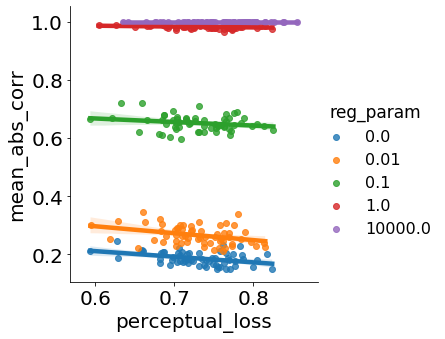

In [58]:
d = df
sns.lmplot('perceptual_loss', 'mean_abs_corr', d, hue='reg_param')
plt.show()

### face id preservation

In [20]:
IM_NUMS = np.arange(1, 50)
regs = [0, 0.01, 0.1, 1, 10000]

dists = {
    reg: [] for reg in regs
}

for r, IM_NUM in tqdm(enumerate(IM_NUMS)):
    im_orig_fname = oj(DIR_IMS, f'{IM_NUM:05}.jpg')
    im_orig = face_recognition.load_image_file(im_orig_fname)
    im_orig_encoding = face_recognition.face_encodings(im_orig)[0]

    for reg in regs:
        im_new_fname = oj(DIR_PROCESSED, f'generated_images_{reg}/{IM_NUM:05}.png')
        im_new = face_recognition.load_image_file(im_new_fname)
        im_new_encoding = face_recognition.face_encodings(im_new)[0]
        # results = face_recognition.compare_faces([im_orig_encoding], im_new_encoding)
        dists[reg].append(face_recognition.face_distance([im_orig_encoding], im_new_encoding)[0])
pd.DataFrame.from_dict(dists).to_csv('processed/09_dists_50.csv')

49it [04:32,  5.55s/it]


In [49]:
df = pd.read_csv('processed/09_dists_50.csv')

In [50]:
df.head()

,Unnamed: 0,0.0,0.01,0.1,1.0,10000.0
0,0,0.282189,0.242982,0.198791,0.506905,0.686844
1,1,0.356663,0.346008,0.339731,0.599027,0.579229
2,2,0.305113,0.306335,0.291769,0.481049,0.606477
3,3,0.320927,0.352912,0.333150,0.481626,0.780579
4,4,0.400456,0.277758,0.272367,0.538123,0.663851


In [ ]:
plt.figure(figsize=(7, 3), dpi=300)
plt.hist(df['0.0'], label='0')
plt.hist(df['0.01'], alpha=0.5, label='$10^{-2}$')
plt.hist(df['0.1'], alpha=0.5, label='$10^{-1}$')
plt.hist(df['1.0'], alpha=0.5, label='$10^0$')
plt.hist(df['10000.0'], alpha=0.5, label='$10^{5}$')
plt.axvline(0.6, linestyle='--', color='black')
plt.legend(title='Regularization')
plt.xlabel('Facial ID distance between original and\nprojected image encoding')
plt.ylabel('Count')
plt.show()

### attr accuracy preservation

In [60]:
print(ks)

['A', 'B', 'C', 'G', 'H', 'M']


In [ ]:
reg_params = df.reg_param.unique()
accs = np.zeros((len(reg_params), len(ks)))
mean_diffs = np.zeros((len(reg_params), len(ks)))
for i, k in enumerate(ks):
    predk = f'pred_{k}'
    # labk = f'lab_{k}'
    labk = f'{config.LABELS[k]}'
    for j, reg_param in enumerate(reg_params):
#     sns.lmplot(predk, labk, df, hue='reg_param')
        d = df[df.reg_param == reg_param]
#         accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
#         mean_diffs[j, i] = np.mean(d[predk][d[labk] == 1]) - np.mean(d[predk][d[labk] == -1])
        
        accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
        mean_diffs[j, i] = np.mean(d[predk][d[labk] == 1]) - np.mean(d[predk][d[labk] == 0])

        
def plot_bars(vals, ylab='Accuracy'):
    fig, ax = plt.subplots(dpi=300)
    ind = np.arange(len(ks)) # the x locations for the groups
    ps = []
    if ylab == 'Accuracy':
        plt.axhline(0.5, color='gray', alpha=0.5)
    ax.grid(zorder=0)
    for i in range(len(reg_params)):
        width = 0.14
        val = vals[i, :].flatten()
        ps.append(ax.bar(ind + width * i, val, width, zorder=3))
    plt.xticks(ind + width * 1.5, [config.LABELS[a] for a in ks], fontsize=10)
    
    plt.ylabel(ylab)
    ax.legend(ps, [f'{reg:.0e}' for reg in reg_params])
    plt.show()
    
# plot_bars(mean_diffs, 'Difference in means')
plot_bars(accs, 'Accuracy')

# look at images

In [153]:
# look at ims
ims = []
for IM_NUM in np.arange(1, 91):
    
    ims.append(mpimg.imread(oj(DIR_IMS, f'{IM_NUM:05}.jpg')))

images = np.array(ims)
images = images.reshape(9, 10, *images.shape[1:])

if type(images) == list:
    images = np.array(images)
N_IMS = images.shape[0]
R = images.shape[0]
C = images.shape[1]
i = 0
plt.figure(figsize=(C * 3, R * 3))
for r in range(R):
    for c in range(C):
        plt.subplot(R, C, i + 1)
        util.imshow(images[r, c])
        plt.title(str(df['gender'].values[i]))

        i += 1

plt.subplot(R, C, N_IMS // 2 + 1)
plt.tight_layout()

### celeba-hq

In [37]:
regs = [0, 0.01, 0.1, 1, 10000] # there are also some for 0.01, 10 -- these weren't as good so let's ignore these
IM_NUMS = np.arange(10)

In [ ]:
R, C = len(IM_NUMS), 1 + len(regs)
plt.figure(dpi=120, figsize=(C*2.5, R*2.5))
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_IMS, f'{IM_NUM:05}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIR_PROCESSED, folder, f'{IM_NUM:05}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIR_PROCESSED, folder, f'{IM_NUM:05}.npy')))
        # print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)
    if r == 0:
        plt.title('orig', fontsize=9)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])
        if r == 0:
            plt.title(f'reg={regs[i]:.2e}', fontsize=9)
    latents = np.array(latents)
plt.tight_layout()

### stylegan2-generated

In [2]:
DIR_ORIG = '../data/annotation-dataset-stylegan2/images'
DIRS_STYLEGAN = '../data_processed/stylegan2'

In [3]:
regs = [0, 0.1, 1, 10000]
IM_NUMS = [0, 1, 10]

In [ ]:
plt.figure(dpi=300)
R, C = len(IM_NUMS), 1 + len(regs)
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.npy')))
        print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])

### celeba (not hq)

In [5]:
DIR_ORIG_CELEBA = '../data/CelebA/Img/img_align_celeba'
DIR_SQUARE_CELEBA = '../data/CelebA/Img/img_square_celeba'

**need to first preprocess celeba to be square before running the pipeline**

In [ ]:
for fname in tqdm(sorted(os.listdir(DIR_ORIG_CELEBA))):
    if '.jpg' in fname:
        im = mpimg.imread(oj(DIR_ORIG_CELEBA, fname))
        if not im.shape[0] == im.shape[1]:
            im = im[20:-20]
        plt.imsave(oj(DIR_SQUARE_CELEBA, fname), im)